In [1]:
%matplotlib inline

from importlib.machinery import SourceFileLoader
import algosdk
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
import re
import json
import itertools
import joblib

from sklearn.ensemble import AdaBoostRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from itertools import product
from collections import Counter
from sklearn.base import RegressorMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image


# load custome module from path.
covid19_WebScrapes = SourceFileLoader("covid19_WebScrapes", "./scripts/covid19_WebScrapes.py").load_module()
merge_prep_data = SourceFileLoader("merge_data", "./scripts/merge_prep_data.py").load_module()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 78)

In [2]:
with open('Merged_Data/data_types.json', 'r') as f:
    dtypes_read = json.load(f)
    
folder_name = datetime.datetime.strftime(datetime.datetime.today(),'%d%b%y')

DF = pd.read_csv('Merged_Data/'+folder_name+'/Final_Merged.csv',dtype=dtypes_read)
#DF = pd.read_csv('Merged_Data/17May20/Final_Merged.csv',dtype=dtypes_read)


DF['bias'] = 1

Include cases data from the 3 most previous days. Right now try to predict 1 week out.

In [3]:
min_value = min(DF['Positive_Cases_PopNormed'])

target_lagged_count = 7
num_lagged_feat_include = 3

for n in range(num_lagged_feat_include) :
    if n == 0 :
        DF['Positive_Cases_PopNormed_Scaled_lagged_1'] = np.log(DF['Positive_Cases_PopNormed']/min_value)
        continue
    new_col = 'Positive_Cases_PopNormed_Scaled_lagged_'+str(n+1)
    DF[new_col] = DF.groupby('FIPS')['Positive_Cases_PopNormed_Scaled_lagged_1'].shift(n)

DF['Positive_Cases_PopNormed_Scaled_Target'] = DF.groupby('FIPS')['Positive_Cases_PopNormed_Scaled_lagged_1'].shift(target_lagged_count)                 

DF = DF.dropna()


In [4]:
DF.head(10)

,FIPS,state,Admin2,Lat,Long_,Date,Positive,Deaths,Positive_Cases_PopNormed,Deaths_PopNormed,New_Positive_Cases_PopNormed_Lagged,New_Positive_Cases_PopNormed,Area (sqmi),population,Proximity,Population_Density,Percent_in_Workforce,Households_per_SqMile,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Mass gathering restrictions,Initial business closure,Educational facilities closed,Non-essential services closed,Stay at home order,Travel severely limited,%_family_households,%_single_male_households,%_single_female_households,%_living_alone,total_household_income,household_income_less_than_25_years,household_income_25_to_45_years,household_income_45_to_65_years,household_income_65_and_older,%_households_with_earnings_last12,%_households_with_no_earnings_last12,%_in_poverty,%_in_poverty_18_to_59,%_in_poverty_60_to_74,%_in_poverty_75_to_85,%_white,%_black,$_other_race,%_male,%_female,%_male_pop_greater_than_60,%_female_pop_greater_than_60,%_workers_less_than_15_to_work,%_workers_15_to_45_to_work,%_workers_greater_than_45_to_work,%_drive_alone_to_work,%_carpool_to_work,%_public_transit_to_work,%_bus_trolley_to_work,%_walked_to_work,%_cab_other_means_of_transportation_to_work,jail_incarceration_rate_per_100k,bias,Positive_Cases_PopNormed_Scaled_lagged_1,Positive_Cases_PopNormed_Scaled_lagged_2,Positive_Cases_PopNormed_Scaled_lagged_3,Positive_Cases_PopNormed_Scaled_Target
7,01001,AL,Autauga,32.539527,-86.644082,03/31/20,7.0,0.0,0.000127,0.000000,0.000018,0.000018,594.44,55200.0,2.714715,92.860507,0.430308,35.520826,-27.0,-4.0,-34.0,35.0,-39.0,17.0,1.0,1.0,1.0,1.0,0.0,0.0,0.71802,0.036372,0.1139,0.251148,58786.0,40051.0,61203.0,79748.0,40822.0,0.739001,5511.0,0.153784,0.078353,0.015868,0.002922,0.768786,0.191395,0.039819,0.486848,0.513152,0.172918,0.215244,0.233613,0.649434,0.116954,0.889824,0.088747,0.001095,0.001095,0.006441,0.013893,275.6,1,7.155045,7.000894,7.000894,5.209135
8,01001,AL,Autauga,32.539527,-86.644082,04/01/20,8.0,0.0,0.000145,0.000000,0.000036,0.000018,594.44,55200.0,2.714715,92.860507,0.430308,35.520826,-16.0,17.0,-34.0,35.0,-39.0,14.0,1.0,1.0,1.0,1.0,0.0,0.0,0.71802,0.036372,0.1139,0.251148,58786.0,40051.0,61203.0,79748.0,40822.0,0.739001,5511.0,0.153784,0.078353,0.015868,0.002922,0.768786,0.191395,0.039819,0.486848,0.513152,0.172918,0.215244,0.233613,0.649434,0.116954,0.889824,0.088747,0.001095,0.001095,0.006441,0.013893,264.9,1,7.288576,7.155045,7.000894,6.595429
9,01001,AL,Autauga,32.539527,-86.644082,04/02/20,10.0,0.0,0.000181,0.000000,0.000036,0.000036,594.44,55200.0,2.714715,92.860507,0.430308,35.520826,-24.0,19.0,-34.0,35.0,-38.0,16.0,1.0,1.0,1.0,1.0,0.0,0.0,0.71802,0.036372,0.1139,0.251148,58786.0,40051.0,61203.0,79748.0,40822.0,0.739001,5511.0,0.153784,0.078353,0.015868,0.002922,0.768786,0.191395,0.039819,0.486848,0.513152,0.172918,0.215244,0.233613,0.649434,0.116954,0.889824,0.088747,0.001095,0.001095,0.006441,0.013893,261.3,1,7.511720,7.288576,7.155045,7.000894
10,01001,AL,Autauga,32.539527,-86.644082,04/03/20,12.0,0.0,0.000217,0.000000,0.000000,0.000036,594.44,55200.0,2.714715,92.860507,0.430308,35.520826,-24.0,37.0,-34.0,35.0,-39.0,17.0,1.0,1.0,1.0,1.0,0.0,0.0,0.71802,0.036372,0.1139,0.251148,58786.0,40051.0,61203.0,79748.0,40822.0,0.739001,5511.0,0.153784,0.078353,0.015868,0.002922,0.768786,0.191395,0.039819,0.486848,0.513152,0.172918,0.215244,0.233613,0.649434,0.116954,0.889824,0.088747,0.001095,0.001095,0.006441,0.013893,248.8,1,7.694042,7.511720,7.288576,7.000894
11,01001,AL,Autauga,32.539527,-86.644082,04/04/20,12.0,0.0,0.000217,0.000000,0.000000,0.000000,594.44,55200.0,2.714715,92.860507,0.430308,35.520826,-39.0,20.0,-34.0,35.0,-25.0,17.0,1.0,1.0,1.0,1.0,1.0,0.0,0.71802,0.036372,0.1139,0.251148,58786.0,40051.0,61203.0,79748.0,40822.0,0.739001,5511.0,0.153784,0.078353,0.015868,0.002922,0

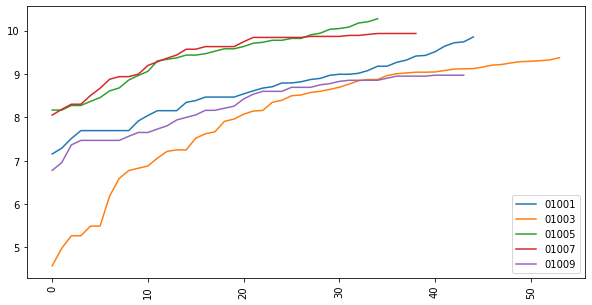

In [5]:
plt.figure(figsize=(10,5))
for fip in DF['FIPS'].unique()[:5] :
    plt.plot(range(len(DF[DF['FIPS']==fip]['Date'])),DF[DF['FIPS']==fip]['Positive_Cases_PopNormed_Scaled_lagged_1'],label = fip)
plt.xticks(rotation=90)
plt.legend()
plt.show()

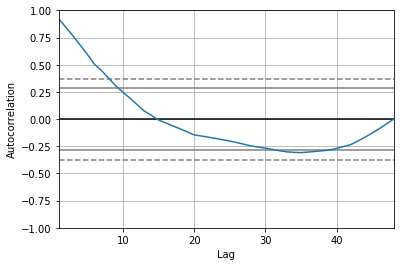

In [6]:
pd.plotting.autocorrelation_plot(DF[DF['FIPS']==DF['FIPS'].unique()[21]]['Positive_Cases_PopNormed_Scaled_lagged_1'])

In [7]:
dates = sorted(DF['Date'].unique())

num_days_holdout = 15

dates_train = dates[:-num_days_holdout]
dates_holdout = dates[-num_days_holdout:]


DF_Train = DF[DF['Date'].isin(dates_train)]
DF_Holdout = DF[DF['Date'].isin(dates_holdout)]


DF_to_Model_Train = DF_Train.drop(['FIPS', 'state', 'Admin2', 'Lat', 'Long_', 
                                   'Date', 'Positive', 'Deaths','Positive_Cases_PopNormed',
                                   'Deaths_PopNormed','New_Positive_Cases_PopNormed_Lagged',
                                   'New_Positive_Cases_PopNormed'],axis=1)

DF_to_Model_Holdout = DF_Holdout.drop(['FIPS', 'state', 'Admin2', 'Lat', 'Long_', 
                                   'Date', 'Positive', 'Deaths','Positive_Cases_PopNormed',
                                   'Deaths_PopNormed','New_Positive_Cases_PopNormed_Lagged',
                                   'New_Positive_Cases_PopNormed'],axis=1)

In [8]:
DF_to_Model_Train_X = DF_to_Model_Train.drop(['Positive_Cases_PopNormed_Scaled_Target'],axis=1)
DF_to_Model_Train_Y = DF_to_Model_Train['Positive_Cases_PopNormed_Scaled_Target']

DF_to_Model_Holdout_X = DF_to_Model_Holdout.drop(['Positive_Cases_PopNormed_Scaled_Target'],axis=1)
DF_to_Model_Holdout_Y = DF_to_Model_Holdout['Positive_Cases_PopNormed_Scaled_Target']

In [9]:
def time_nested_CV(ada_model,num_splits,df_train,date_init='03/01/20',method='window',window_size=None) :
    
    if method=='window' :
        if window_size is None :
            raise TypeError('Input window size')
    
    scores = []
    
    dates = sorted(df_train['Date'].unique())
    init_ind = dates.index(date_init)
    date_indices = list(map(int,np.floor(np.linspace(init_ind,len(dates)-4,num_splits))))
    
    prev_ind = 0
    for ind in date_indices :
        if method == 'window' :
            date_range_train = dates[prev_ind:ind]
            prev_ind=ind-window_size
        elif method == 'all' :
            date_range_train = dates[:ind]
        else :
            raise TypeError('input valid argument')
        date_range_val = dates[ind:ind+4]
        
        train_set = df_train[df_train['Date'].isin(date_range_train)]
        
        validation_set = df_train[df_train['Date'].isin(date_range_val)]
        
        
        print(date_range_train[0]+"-"+date_range_train[-1],date_range_val[0]+"-"+date_range_val[-1])
        print(train_set.shape[0] , validation_set.shape[0])
        
        to_train = train_set.drop(['FIPS', 'state', 'Admin2', 'Lat', 'Long_', 
                                   'Date', 'Positive', 'Deaths','Positive_Cases_PopNormed',
                                   'Deaths_PopNormed','New_Positive_Cases_PopNormed_Lagged',
                                   'New_Positive_Cases_PopNormed'],axis=1)
        to_validate = validation_set.drop(['FIPS', 'state', 'Admin2', 'Lat', 'Long_', 
                                   'Date', 'Positive', 'Deaths','Positive_Cases_PopNormed',
                                   'Deaths_PopNormed','New_Positive_Cases_PopNormed_Lagged',
                                   'New_Positive_Cases_PopNormed'],axis=1)
        
        to_train_X = to_train.drop(['Positive_Cases_PopNormed_Scaled_Target'],axis=1)
        to_train_Y = to_train['Positive_Cases_PopNormed_Scaled_Target']
        
        to_validate_X = to_validate.drop(['Positive_Cases_PopNormed_Scaled_Target'],axis=1)
        to_validate_Y = to_validate['Positive_Cases_PopNormed_Scaled_Target']

        ada_mod.fit(to_train_X,to_train_Y)

        R2 = ada_mod.score(to_validate_X,to_validate_Y)
        
        scores.append(R2)
        
    return scores

In [10]:
def grid_search(base_hyperparams,ada_hyperparams,num_splits,df_train,date_init='03/01/20',method='window') :
    
    hyperparams_use = list(itertools.product(*base_hyperparams.values(),*ada_hyperparams.values()))
    
    output = np.zeros((len(hyperparams_use),num_splits+len(hyperparams_use[0])),dtype='object')
    
    for n,hyp in enumerate(hyperparams_use) :
        
        print(hyp,'{} of {}'.format(n,len(hyperparams_use)))
        
        base_grid = {list(base_hyperparams.keys())[i] : hyp[i] for i in range(len(base_hyperparams))}
        ada_grid = {list(ada_hyperparams.keys())[i] : hyp[i+len(base_hyperparams)] for 
                    i in range(len(ada_hyperparams))}
        
        base_estimator = DecisionTreeRegressor()
        base_estimator.set_params(**base_grid)
        
        ada_grid['base_estimator'] = base_estimator
        
        ada_mod = AdaBoostRegressor()
        ada_mod.set_params(**ada_grid)
        
        
        output[n][:len(hyp)] = hyp
        output[n][len(hyp):] = time_nested_CV(ada_mod,num_splits,df_train,date_init,method,window_size=30)
        
    columns_add = list(base_grid.keys())+list(ada_grid.keys())[:-1]+['split_'+str(i+1) for i in range(num_splits)]
    
    return pd.DataFrame(output,columns=columns_add)
    
    

In [454]:
base_hyperparams = {'max_depth':[10,25,None]}
ada_hyperparams = {'n_estimators':[5,10,25,50],'loss':['linear','square'],'learning_rate':[.1,1]}

In [455]:
grid_search_df = grid_search(base_hyperparams,ada_hyperparams,10,DF_Train,method='window')

(10, 5, 'linear', 0.1) 0 of 48
(10, 5, 'linear', 1) 1 of 48
(10, 5, 'square', 0.1) 2 of 48
(10, 5, 'square', 1) 3 of 48
(10, 10, 'linear', 0.1) 4 of 48
(10, 10, 'linear', 1) 5 of 48
(10, 10, 'square', 0.1) 6 of 48
(10, 10, 'square', 1) 7 of 48
(10, 25, 'linear', 0.1) 8 of 48
(10, 25, 'linear', 1) 9 of 48
(10, 25, 'square', 0.1) 10 of 48
(10, 25, 'square', 1) 11 of 48
(10, 50, 'linear', 0.1) 12 of 48
(10, 50, 'linear', 1) 13 of 48
(10, 50, 'square', 0.1) 14 of 48
(10, 50, 'square', 1) 15 of 48
(25, 5, 'linear', 0.1) 16 of 48
(25, 5, 'linear', 1) 17 of 48
(25, 5, 'square', 0.1) 18 of 48
(25, 5, 'square', 1) 19 of 48
(25, 10, 'linear', 0.1) 20 of 48
(25, 10, 'linear', 1) 21 of 48
(25, 10, 'square', 0.1) 22 of 48
(25, 10, 'square', 1) 23 of 48
(25, 25, 'linear', 0.1) 24 of 48
(25, 25, 'linear', 1) 25 of 48
(25, 25, 'square', 0.1) 26 of 48
(25, 25, 'square', 1) 27 of 48
(25, 50, 'linear', 0.1) 28 of 48
(25, 50, 'linear', 1) 29 of 48
(25, 50, 'square', 0.1) 30 of 48
(25, 50, 'square', 1) 31 

In [456]:
grid_search_df['mean'] = np.mean(grid_search_df[grid_search_df.columns[-10:]],axis=1)
grid_search_df['std'] = np.std(grid_search_df[grid_search_df.columns[-11:-1]],axis=1)
grid_search_df['%_CV'] = grid_search_df['std'] / grid_search_df['mean']

grid_search_df.sort_values('%_CV',ascending=True)

,max_depth,n_estimators,loss,learning_rate,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8,split_9,split_10,mean,std,%_CV
39,None,10,square,1,0.499416,0.524408,0.482818,0.636553,0.690662,0.759283,0.836143,0.894973,0.918014,0.937911,0.718018,0.168314,0.234415
38,None,10,square,0.1,0.634666,0.45518,0.452052,0.608772,0.699878,0.769874,0.837334,0.896423,0.917881,0.935812,0.720787,0.171782,0.238325
26,25,25,square,0.1,0.524165,0.478448,0.470726,0.607003,0.710994,0.766828,0.831046,0.8958,0.918277,0.934414,0.713770,0.173786,0.243476
25,25,25,linear,1,0.511304,0.488101,0.446518,0.602474,0.695198,0.768597,0.828681,0.896719,0.916325,0.936001,0.708992,0.177748,0.250705
16,25,5,linear,0.1,0.47663,0.438946,0.52372,0.614729,0.698239,0.763633,0.832429,0.896983,0.915191,0.935043,0.709554,0.178163,0.251091
46,None,50,square,0.1,0.511395,0.449542,0.466876,0.62824,0.694295,0.767949,0.835611,0.894172,0.916853,0.93414,0.709907,0.178719,0.251750
40,None,25,linear,0.1,0.513516,0.447206,0.463276,0.626441,0.698907,0.766794,0.833205,0.897062,0.915558,0.935203,0.709717,0.179447,0.252843
43,None,25,square,1,0.56772,0.40419,0.46507,0.607597,0.708769,0.763776,0.829424,0.898575,0.919112,0.935101,0.709933,0.182032,0.256407
34,None,5,square,0.1,0.487595,0.473986,0.431603,0.626206,0.706861,0.771198,0.831259,0.896863,0.91539,0.932173,0.707313,0.182905,0.258592
28,25,50,linear,0.1,0.535024,0.400841,0.47296,0.61011,0.699124,0.771532,0.833649,0.894678,0.914893,0.936702,0.706951,0.184104,0.260420


In [11]:
base_estimator = DecisionTreeRegressor(max_depth=None)
ada_mod = AdaBoostRegressor(base_estimator=base_estimator,loss='square',n_estimators=10,learning_rate=.1)

In [25]:
time_nested_CV(ada_mod,10,DF_Train,'03/01/20','window',30)

01/29/20-02/29/20 03/01/20-03/04/20
227 44
01/31/20-03/06/20 03/07/20-03/10/20
291 74
02/06/20-03/12/20 03/13/20-03/16/20
410 325
02/12/20-03/18/20 03/19/20-03/22/20
1028 1291
02/18/20-03/24/20 03/25/20-03/28/20
3269 3258
02/24/20-03/31/20 04/01/20-04/04/20
10239 6690
03/02/20-04/06/20 04/07/20-04/10/20
20816 8851
03/08/20-04/12/20 04/13/20-04/16/20
34352 9989
03/14/20-04/18/20 04/19/20-04/22/20
49328 10564
03/20/20-04/25/20 04/26/20-04/29/20
67105 10896


[0.6260272155994862,
 0.6460437432769763,
 0.6650663119270885,
 0.6886034840643693,
 0.6560786456717296,
 0.7268477509139003,
 0.7847803416029557,
 0.841419457249259,
 0.8923491310628101,
 0.9291186035460063]

In [12]:
ada_mod.fit(DF_to_Model_Train_X,DF_to_Model_Train_Y)

holdout_preds = ada_mod.predict(DF_to_Model_Holdout_X)

DF_predicted = DF_to_Model_Holdout_X.copy()
DF_predicted['preds'] = holdout_preds

In [13]:
ada_mod.score(DF_to_Model_Holdout_X,DF_to_Model_Holdout_Y)

0.9241388347831672

In [14]:
feat_importance = dict(zip(DF_to_Model_Holdout_X.columns,ada_mod.feature_importances_))
sorted(feat_importance.items(), key=lambda x: x[1])

[('Travel severely limited', 0.0),
 ('bias', 0.0),
 ('Initial business closure', 8.980097952964147e-05),
 ('Educational facilities closed', 9.395686344588974e-05),
 ('Non-essential services closed', 0.00018338263775493355),
 ('Mass gathering restrictions', 0.0001994465446528169),
 ('Stay at home order', 0.0002448791596980218),
 ('household_income_45_to_65_years', 0.0007308323214431912),
 ('total_household_income', 0.0007371238218640666),
 ('%_in_poverty', 0.0007507877279455468),
 ('%_in_poverty_18_to_59', 0.0008355285989093541),
 ('%_households_with_earnings_last12', 0.0009248669807907392),
 ('household_income_25_to_45_years', 0.000964981890953665),
 ('%_bus_trolley_to_work', 0.0009812843165197805),
 ('%_female', 0.0009995328956833424),
 ('%_male', 0.0010041644404498026),
 ('%_family_households', 0.0010215352124447632),
 ('%_drive_alone_to_work', 0.001106021829807987),
 ('%_male_pop_greater_than_60', 0.0011150225976007207),
 ('Percent_in_Workforce', 0.001143197362467656),
 ('%_in_pover

In [29]:
DF_predicted = DF.drop(['FIPS', 'state', 'Admin2', 'Lat', 'Long_', 
                        'Date', 'Positive', 'Deaths','Positive_Cases_PopNormed',
                        'Deaths_PopNormed','New_Positive_Cases_PopNormed_Lagged',
                        'New_Positive_Cases_PopNormed'],axis=1)
DF_predicted['preds'] = ada_mod.predict(DF_predicted.drop('Positive_Cases_PopNormed_Scaled_Target',axis=1))
DF_predicted['truth'] = DF['Positive_Cases_PopNormed_Scaled_Target']

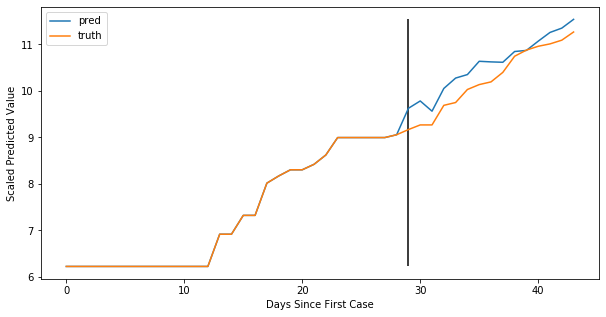

In [41]:
fip = DF['FIPS'].unique()[6]
#fip = '36061'

plt.figure(figsize=(10,5))
plt.plot(range(DF_predicted[(DF['FIPS']==fip)].shape[0]),DF_predicted[(DF['FIPS']==fip)]['preds'],label='pred')
plt.plot(range(DF_predicted[(DF['FIPS']==fip)].shape[0]),DF_predicted[(DF['FIPS']==fip)]['truth'],label='truth')
plt.vlines(x=DF_predicted[(DF['FIPS']==fip)].shape[0]-num_days_holdout,
           ymin=min([min(DF_predicted[(DF['FIPS']==fip)]['preds']),min(DF_predicted[(DF['FIPS']==fip)]['truth'])]),
           ymax=max([max(DF_predicted[(DF['FIPS']==fip)]['preds']),max(DF_predicted[(DF['FIPS']==fip)]['truth'])]))
plt.ylabel('Scaled Predicted Value')
plt.xlabel('Days Since First Case')
plt.legend()
plt.show()

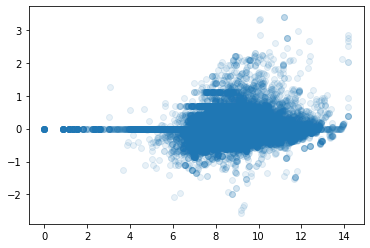

In [468]:
plt.scatter(DF_predicted['truth'],DF_predicted['truth']-DF_predicted['preds'],alpha=.1)

In [464]:
joblib.dump(ada_mod,'AdaBoost_Model_19MAY2020.pkl')

['AdaBoost_Model_19MAY2020.pkl']